# Sound scene classifier for hearing aids (Oticon Audio Explorers challenge 2023)

## Imports

In [2]:
!pip install visualkeras
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 kB 41.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats
import time
import csv

import itertools

import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight

import visualkeras
from PIL import ImageFont

## Helper functions

In [30]:
########################## DATA EXPLORATION ##########################
def np_value_counts(arr):
    """
    Returns the unique values and their counts in a numpy array.
    """
    unique, counts = np.unique(arr, return_counts=True)
    return dict(zip(unique, counts))

def replace_classes_num_by_name(dict1, classes):
    return dict((classes[key], value) for (key, value) in dict1.items())

def plot_classes_dist(data):
    # Calculate classes distribution
    classes_counts = np_value_counts(data)
    data = replace_classes_num_by_name(classes_counts, classes)
    print(data)

    # Plot
    labels = list(data.keys())
    values = list(data.values())

    plt.bar(labels, values, color='lavender', edgecolor='indigo')
    plt.title('Classes Distribution')
    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)

    plt.show()

def plot_sets_dist(train, val, test=None):
    datasets = [train, val]
    if test is not None:
        datasets.append(test)

    fig, axes = plt.subplots(1, len(datasets), figsize=(15, 5))

    for i, data in enumerate(datasets):
        # Calculate classes distribution
        classes_counts = np_value_counts(data)
        data = replace_classes_num_by_name(classes_counts, classes)

        # Plot
        labels = list(data.keys())
        values = list(data.values())

        axes[i].bar(labels, values, color='lavender', edgecolor='indigo')
        axes[i].set_title('Classes Distribution {}'.format(['train', 'val', 'test'][i]))
        axes[i].set_xlabel('Categories')
        axes[i].set_ylabel('Counts')
        axes[i].tick_params(axis='x', labelrotation=45)

    plt.show()

########################## DATA DISTRIBUTION ##########################
def split_data_stratified(X, Y, val_size_ratio, test_size_ratio, random_state=42):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size_ratio, random_state=random_state)
    train_val_idx, test_idx = next(sss.split(X, Y))
    x_train_val, y_train_val = X[train_val_idx], Y[train_val_idx]
    
    val_size = val_size_ratio / (1 - test_size_ratio)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
    train_idx, val_idx = next(sss.split(x_train_val, y_train_val))
    x_train, y_train = x_train_val[train_idx], y_train_val[train_idx]
    x_val, y_val = x_train_val[val_idx], y_train_val[val_idx]
    
    x_test, y_test = X[test_idx], Y[test_idx]
    
    return x_train, y_train, x_val, y_val, x_test, y_test

########################## PREDICTIONS ##########################
def make_predictions(x_eval):
    y_prob = model.predict(x_eval)
    y_pred = np.argmax(y_prob, axis=1)
    return y_prob, y_pred

def make_final_predictions_csv(X_test, output_file='predictions.csv'):
    # Make predictions
    start_stopwatch = time.time()
    Y_prob, Y_pred = make_predictions(X_test)
    predictions_time = time.time()-start_stopwatch

    # Print timing results
    print(f"Model predicting time: {predictions_time} seconds")
    time_per_prediction = predictions_time / Y_pred.shape[0]
    print(f'Time per prediction: {time_per_prediction} seconds')

    # Plot results distribution
    plot_classes_dist(Y_pred)

    # Write predictions to file
    with open(output_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(Y_pred.reshape(-1, 1))

def make_final_predictions_txt(X_test, output_file='predictions.txt'):
    # Make predictions
    start_stopwatch = time.time()
    Y_prob, Y_pred = make_predictions(X_test)
    predictions_time = time.time()-start_stopwatch

    # Print timing results
    print(f"Model predicting time: {predictions_time} seconds")
    time_per_prediction = predictions_time / Y_pred.shape[0]
    print(f'Time per prediction: {time_per_prediction} seconds')

    # Plot results distribution
    plot_classes_dist(Y_pred)

    # Write predictions to file
    with open(output_file, 'w', encoding='utf-8') as file:
        for pred in Y_pred:
            file.write(str(pred) + '\n')

########################## EVALUATION ##########################
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          print_if_normalized=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, [classes[k] for k in classes.keys()], rotation=45)
    plt.yticks(tick_marks, [classes[k] for k in classes.keys()])
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if print_if_normalized: print("Normalized confusion matrix")
    else:
        if print_if_normalized: print('Confusion matrix, without normalization')

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_model(y_prob, y_pred, y_eval):
    # Confusion Matrix
    cm = confusion_matrix(y_eval, y_pred)
    plot_labels = classes
    plot_confusion_matrix(cm=cm, classes=plot_labels, title='Confusion Matrix', cmap=plt.cm.Purples)

    # Classification report for precision, recall f1-score and accuracy
    report = classification_report(y_true=y_eval, y_pred=y_pred)
    print('Classification report:\n', report)
    plt.show()
    
    # AUC score
    auc_score = roc_auc_score(y_eval, y_prob, multi_class='ovr')
    print('AUC score:', auc_score)

def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

################################################################################

## Load data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

# Define data and models paths
datasets_path = '/content/drive/MyDrive/Colab Notebooks/datasets/oticon_challenge_2023/npy (for option 1)'
models_path = os.path.join(datasets_path, "models")


training_data_filename = "training.npy"
training_labels_filename = "training_labels.npy"
test_data_filename = "test.npy"

training_data_path = os.path.join(datasets_path, training_data_filename)
training_labels_path = os.path.join(datasets_path, training_labels_filename)
test_data_path = os.path.join(datasets_path, test_data_filename)


# Load data from .npy file
X = np.load(training_data_path)
Y = np.load(training_labels_path)
X_test = np.load(test_data_path)

# Define classes
classes = {0:'Other', 1:'Music', 2:'Human voice', 3:'Engine Sounds', 4:'Alarm'}

# Show data shape
print(f"Training data shape: {X.shape}")
print(f"Training labels shape: {Y.shape}")
print(f"Test data shape: {X_test.shape}")


Mounted at /content/drive
Training data shape: (52890, 32, 96)
Training labels shape: (52890,)
Test data shape: (5347, 32, 96)


## Explore data

{'Other': 14530, 'Music': 27340, 'Human voice': 4823, 'Engine Sounds': 4412, 'Alarm': 1785}


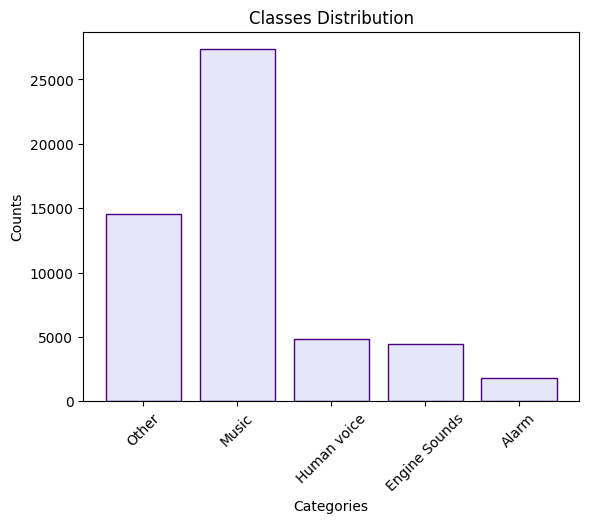

In [6]:
# Plot classes distribution
plot_classes_dist(Y)

The **training data** is formed by 52890 sound samples, each containing 32 frequency band, of which each has 96 time frames.  
The **training labels** is formed by the classes of the 52890 sound samples , which can be: array([0, 1, 2, 3, 4], dtype=int32)  
The **test data** is formed by 5347 sound samples, each containing 32 frequency band, of which each has 96 time frames. 

The **training data distribution** is: {'Other': 14530, 'Music': 27340, 'Human voice': 4823, 'Engine Sounds': 4412, 'Alarm': 1785}




## Model 1 and Model 2: CNN (training_set: 80%, val_set:20%) 

### Create neural network 

Epoch 1/10
1323/1323 [==============================] - 11s 5ms/step - loss: 0.9715 - accuracy: 0.6916 - val_loss: 0.7342 - val_accuracy: 0.7405
Epoch 2/10
1323/1323 [==============================] - 7s 5ms/step - loss: 0.6882 - accuracy: 0.7558 - val_loss: 0.6321 - val_accuracy: 0.7826
Epoch 3/10
1323/1323 [==============================] - 6s 5ms/step - loss: 0.6181 - accuracy: 0.7800 - val_loss: 0.6239 - val_accuracy: 0.7800
Epoch 4/10
1323/1323 [==============================] - 7s 6ms/step - loss: 0.5605 - accuracy: 0.8001 - val_loss: 0.5656 - val_accuracy: 0.8063
Epoch 5/10
1323/1323 [==============================] - 6s 5ms/step - loss: 0.5079 - accuracy: 0.8171 - val_loss: 0.5644 - val_accuracy: 0.8067
Epoch 6/10
1323/1323 [==============================] - 7s 5ms/step - loss: 0.4708 - accuracy: 0.8273 - val_loss: 0.5614 - val_accuracy: 0.8117
Epoch 7/10
1323/1323 [==============================] - 6s 5ms/step - loss: 0.4449 - accuracy: 0.8378 - val_loss: 0.5806 - val_accuracy

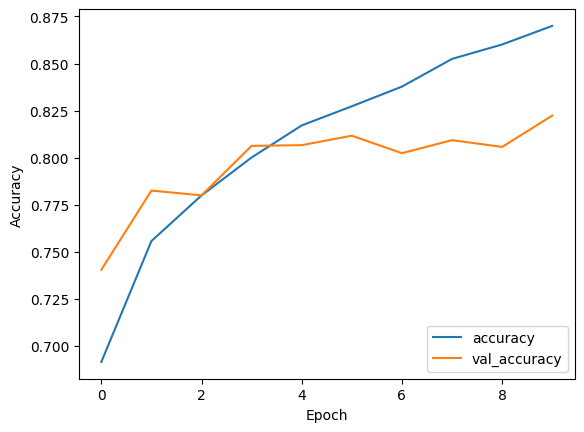

CPU times: user 1min 13s, sys: 5.36 s, total: 1min 19s
Wall time: 1min 12s


In [20]:
%%time
# Split the data
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)

# Build the neural network
model = tf.keras.Sequential([
  layers.Input(shape=(32, 96, 1)),
  layers.Conv2D(16, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(5, activation='softmax')
])

# Train the neural network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

# Plot the history
plot_history(history)

### Show sets distribution

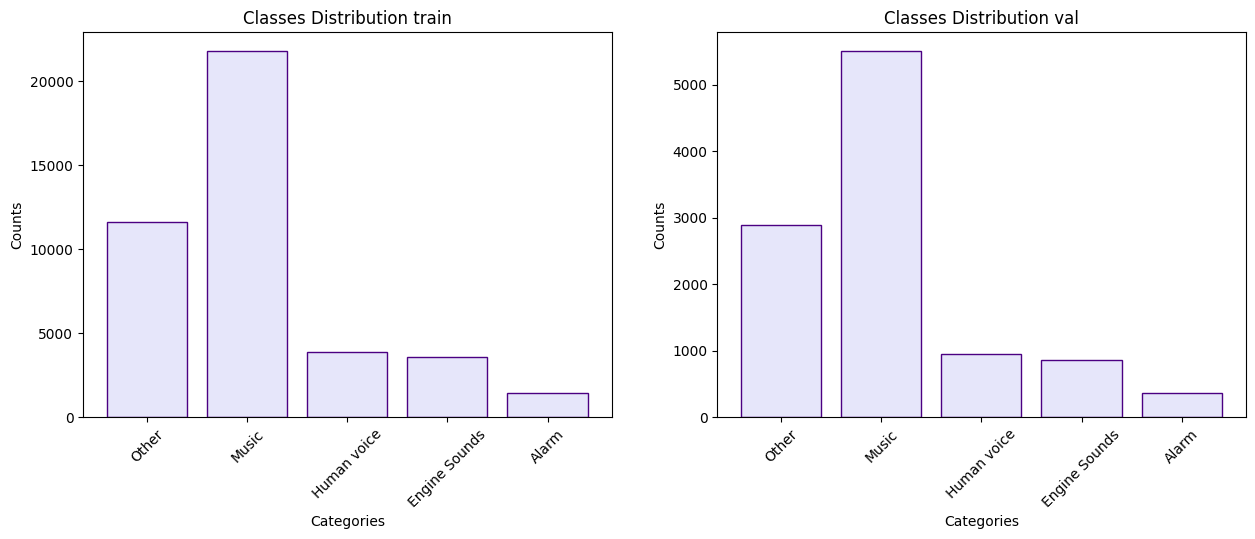

In [30]:
# Show subsets distribution
plot_sets_dist(y_train, y_val)

### Save model

In [ ]:
model.save(os.path.join(models_path, "model_7"))

Model 1: Best model  
Model 2: No difference from one but worst  
Model 3: Added test_set  
Model 4: Added equal distribution of classes to different sets

### Load model

In [32]:
model = load_model(os.path.join(models_path, "model_1"))


### Evaluate model

331/331 [==============================] - 1s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88      2889
           1       0.96      0.97      0.97      5515
           2       0.80      0.88      0.84       950
           3       0.75      0.80      0.78       855
           4       0.89      0.84      0.86       369

    accuracy                           0.91     10578
   macro avg       0.86      0.87      0.87     10578
weighted avg       0.92      0.91      0.91     10578



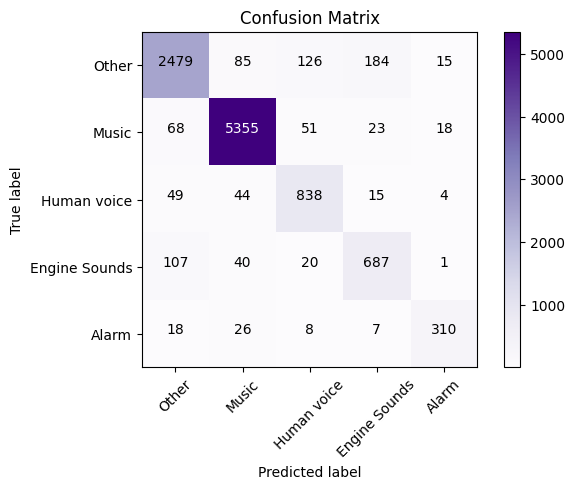

AUC score: 0.9825342760608887


In [33]:
# Set evaluation data, predict and evaluate
# If there's a test set, that will be used as evaluation data, otherwise we use the validation set
x_eval = x_val
y_eval = y_val

# Make predictions and evaluate model
y_prob, y_pred = make_predictions(x_eval)
evaluate_model(y_prob, y_pred, y_eval)

### Number of parameters

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 94, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 47, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 22, 32)        0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 4224)              0         
                                                                 
 dense_8 (Dense)             (None, 64)               

The NN has a total of 275,525 parameters.

### Visualize network architecture

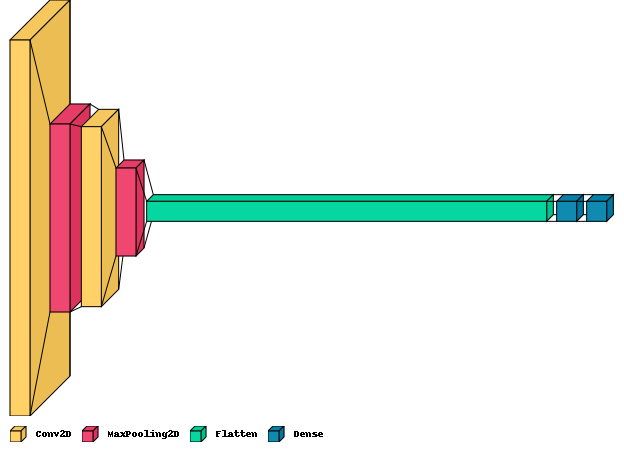

In [ ]:
# Plot model architecture
visualkeras.layered_view(model, legend=True)

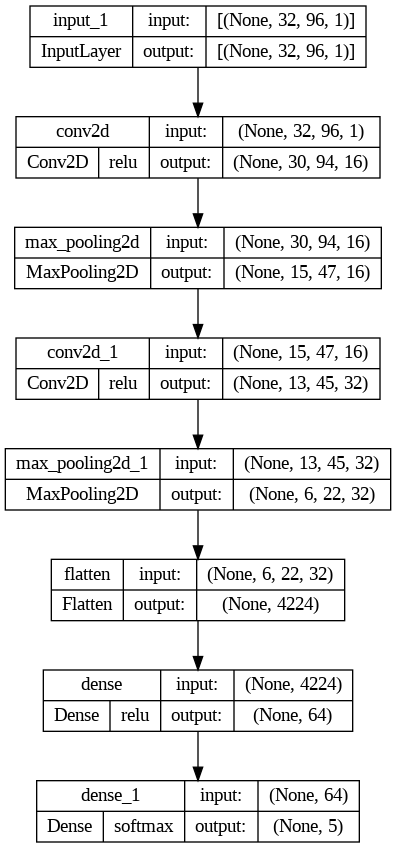

In [ ]:
# Plot model diagram
tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)

## Model 3: Create model using (training_set: 80%, val_set:10%, test_set:10%) 

In [ ]:
# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.111)

# Build the neural network
model = tf.keras.Sequential([
  layers.Input(shape=(32, 96, 1)),
  layers.Conv2D(16, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(5, activation='softmax')
])

# Train the neural network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

# Plot the history
plot_history(history)

Epoch 1/10
1323/1323 [==============================] - 113s 83ms/step - loss: 0.8742 - accuracy: 0.7100 - val_loss: 0.7001 - val_accuracy: 0.7521
Epoch 2/10
1323/1323 [==============================] - 104s 79ms/step - loss: 0.6214 - accuracy: 0.7818 - val_loss: 0.5824 - val_accuracy: 0.7903
Epoch 3/10
1323/1323 [==============================] - 102s 77ms/step - loss: 0.5432 - accuracy: 0.8099 - val_loss: 0.5437 - val_accuracy: 0.8030
Epoch 4/10
1323/1323 [==============================] - 102s 77ms/step - loss: 0.4838 - accuracy: 0.8295 - val_loss: 0.5453 - val_accuracy: 0.8102
Epoch 5/10
1323/1323 [==============================] - 98s 74ms/step - loss: 0.4391 - accuracy: 0.8412 - val_loss: 0.5372 - val_accuracy: 0.8077
Epoch 6/10
1323/1323 [==============================] - 99s 75ms/step - loss: 0.3906 - accuracy: 0.8588 - val_loss: 0.5685 - val_accuracy: 0.8034
Epoch 7/10
1323/1323 [==============================] - 100s 75ms/step - loss: 0.3520 - accuracy: 0.8736 - val_loss: 0.5

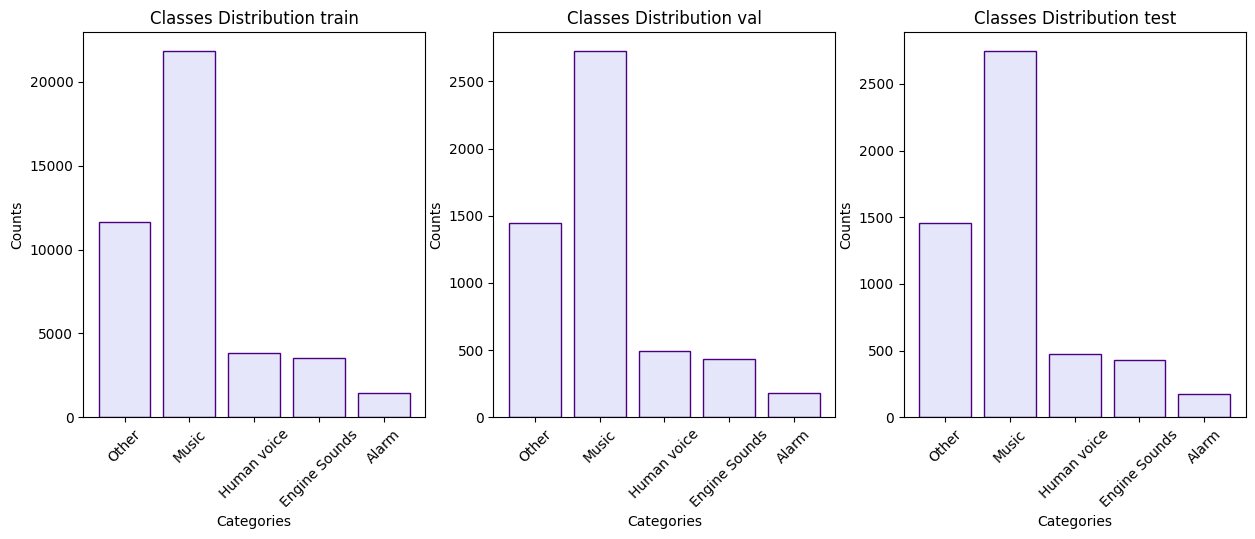

In [ ]:
# Show subsets distribution
plot_sets_dist(y_train, y_val, y_test)

166/166 [==============================] - 5s 30ms/step
Classification report:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74      1458
           1       0.92      0.92      0.92      2750
           2       0.59      0.67      0.63       476
           3       0.57      0.59      0.58       432
           4       0.66      0.59      0.62       173

    accuracy                           0.81      5289
   macro avg       0.70      0.70      0.70      5289
weighted avg       0.81      0.81      0.81      5289



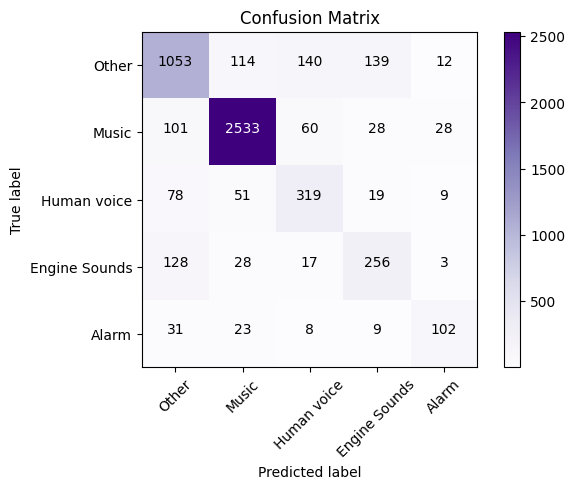

AUC score: 0.9300300178626658


In [ ]:
# Save model
# model.save(os.path.join(models_path, "model_3"))
#Load model
# model = load_model(os.path.join(models_path, "model_3"))

# Set evaluation data, predict and evaluate
# If there's a test set, that will be used as evaluation data, otherwise we use the validation set
x_eval = x_test
y_eval = y_test

# Make predictions and evaluate model
y_prob, y_pred = make_predictions(x_eval)
evaluate_model(y_prob, y_pred, y_eval)

## Model 4: Create model using equal class distribution in each set StratifiedShuffleSplit (training_set: 80%, val_set:10%, test_set:10%)

Epoch 1/10
1323/1323 [==============================] - 8s 5ms/step - loss: 0.9838 - accuracy: 0.6994 - val_loss: 0.6401 - val_accuracy: 0.7712
Epoch 2/10
1323/1323 [==============================] - 6s 5ms/step - loss: 0.6345 - accuracy: 0.7723 - val_loss: 0.6010 - val_accuracy: 0.7879
Epoch 3/10
1323/1323 [==============================] - 6s 5ms/step - loss: 0.5602 - accuracy: 0.7977 - val_loss: 0.5692 - val_accuracy: 0.7988
Epoch 4/10
1323/1323 [==============================] - 7s 6ms/step - loss: 0.5090 - accuracy: 0.8176 - val_loss: 0.5878 - val_accuracy: 0.7901
Epoch 5/10
1323/1323 [==============================] - 6s 5ms/step - loss: 0.4697 - accuracy: 0.8298 - val_loss: 0.5570 - val_accuracy: 0.8022
Epoch 6/10
1323/1323 [==============================] - 8s 6ms/step - loss: 0.4356 - accuracy: 0.8429 - val_loss: 0.5643 - val_accuracy: 0.8056
Epoch 7/10
1323/1323 [==============================] - 6s 4ms/step - loss: 0.4020 - accuracy: 0.8549 - val_loss: 0.6140 - val_accuracy:

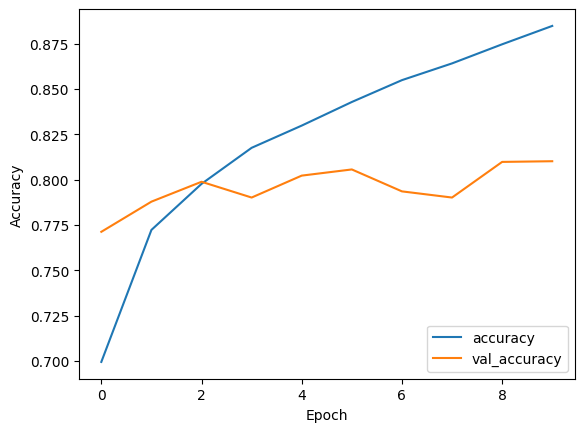

CPU times: user 1min 7s, sys: 5.76 s, total: 1min 13s
Wall time: 1min 8s


In [14]:
%%time
# Split the data using StratifiedShuffleSplit
# We set the random_state parameter to a fixed value (42) to ensure that the splits are reproducible.
x_train, y_train, x_val, y_val, x_test, y_test = split_data_stratified(X, Y, val_size_ratio=0.1, test_size_ratio=0.1)

# Build the neural network
model = tf.keras.Sequential([
  layers.Input(shape=(32, 96, 1)),
  layers.Conv2D(16, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(5, activation='softmax')
])

# Train the neural network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

# Plot the history
plot_history(history)

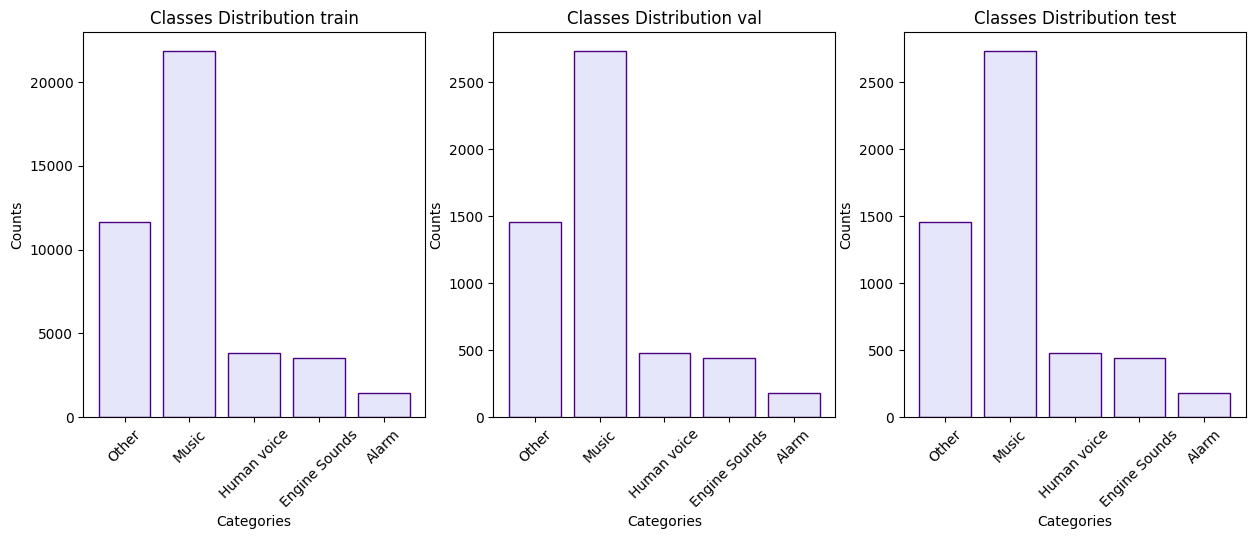

In [15]:
# Show subsets distribution
plot_sets_dist(y_train, y_val, y_test)

166/166 [==============================] - 0s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       0.72      0.82      0.77      1453
           1       0.93      0.92      0.93      2734
           2       0.77      0.55      0.64       482
           3       0.58      0.54      0.56       441
           4       0.63      0.54      0.58       179

    accuracy                           0.82      5289
   macro avg       0.72      0.67      0.69      5289
weighted avg       0.82      0.82      0.81      5289



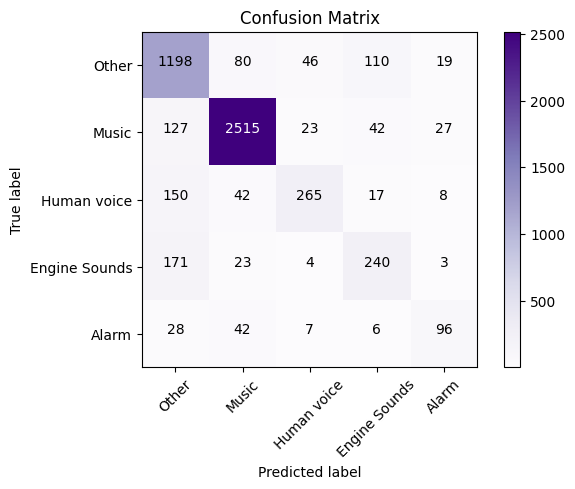

AUC score: 0.9340189607962044


In [16]:
# Save model
# model.save(os.path.join(models_path, "model_4"))
#Load model
# model = load_model(os.path.join(models_path, "model_4"))

# Set evaluation data, predict and evaluate
# If there's a test set, that will be used as evaluation data, otherwise we use the validation set
x_eval = x_test
y_eval = y_test

# Make predictions and evaluate model
y_prob, y_pred = make_predictions(x_eval)
evaluate_model(y_prob, y_pred, y_eval)

## Model 5: Create model using equal class distribution in each set StratifiedShuffleSplit (training_set: 80%, val_set:15%, test_set:5%) 

Epoch 1/10
1323/1323 [==============================] - 61s 45ms/step - loss: 0.9101 - accuracy: 0.7026 - val_loss: 0.6861 - val_accuracy: 0.7462
Epoch 2/10
1323/1323 [==============================] - 60s 45ms/step - loss: 0.6562 - accuracy: 0.7666 - val_loss: 0.6031 - val_accuracy: 0.7846
Epoch 3/10
1323/1323 [==============================] - 60s 45ms/step - loss: 0.5730 - accuracy: 0.7956 - val_loss: 0.5831 - val_accuracy: 0.7922
Epoch 4/10
1323/1323 [==============================] - 58s 44ms/step - loss: 0.5189 - accuracy: 0.8133 - val_loss: 0.5566 - val_accuracy: 0.8004
Epoch 5/10
1323/1323 [==============================] - 59s 45ms/step - loss: 0.4744 - accuracy: 0.8287 - val_loss: 0.5394 - val_accuracy: 0.8069
Epoch 6/10
1323/1323 [==============================] - 58s 44ms/step - loss: 0.4360 - accuracy: 0.8427 - val_loss: 0.6141 - val_accuracy: 0.7857
Epoch 7/10
1323/1323 [==============================] - 59s 45ms/step - loss: 0.3948 - accuracy: 0.8576 - val_loss: 0.5804 -

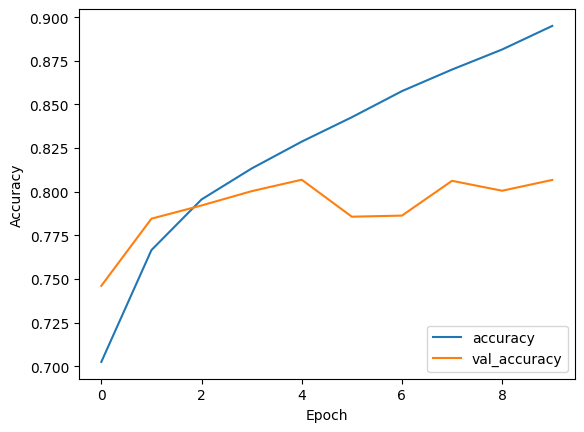

CPU times: user 15min 34s, sys: 16.5 s, total: 15min 50s
Wall time: 10min 23s


In [7]:
%%time
# Split the data using StratifiedShuffleSplit
# We set the random_state parameter to a fixed value (42) to ensure that the splits are reproducible.
x_train, y_train, x_val, y_val, x_test, y_test = split_data_stratified(X, Y, val_size_ratio=0.15, test_size_ratio=0.05)

# Build the neural network
model = tf.keras.Sequential([
  layers.Input(shape=(32, 96, 1)),
  layers.Conv2D(16, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(5, activation='softmax')
])

# Train the neural network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

# Plot the history
plot_history(history)

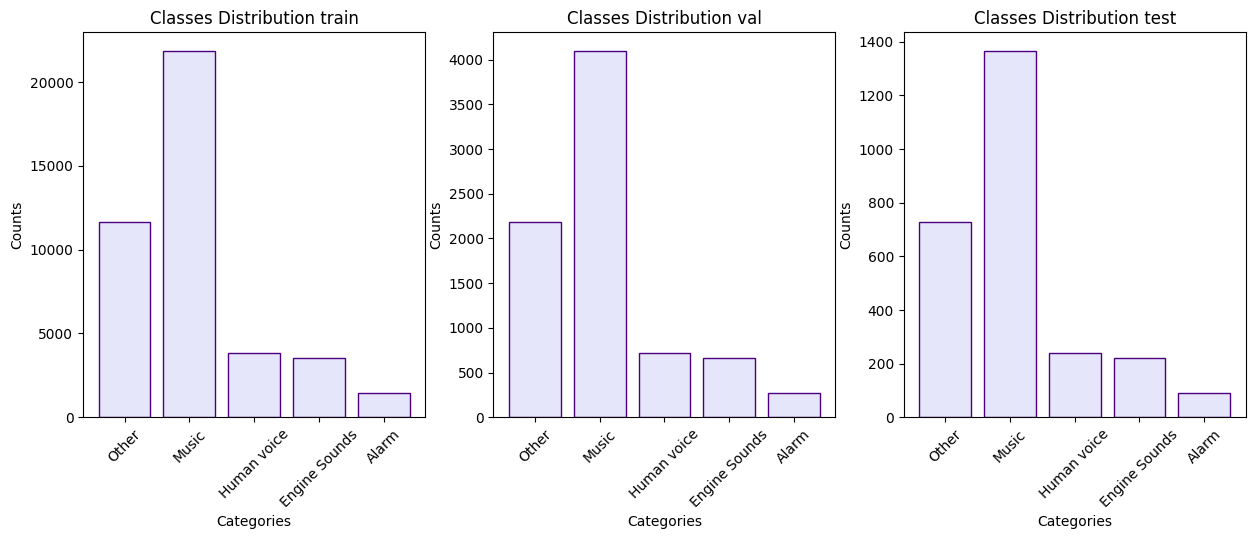

In [8]:
# Show subsets distribution
plot_sets_dist(y_train, y_val, y_test)

83/83 [==============================] - 1s 13ms/step
Classification report:
               precision    recall  f1-score   support

           0       0.70      0.80      0.75       727
           1       0.91      0.92      0.91      1367
           2       0.70      0.62      0.66       241
           3       0.52      0.36      0.43       221
           4       0.69      0.46      0.55        89

    accuracy                           0.80      2645
   macro avg       0.71      0.63      0.66      2645
weighted avg       0.79      0.80      0.79      2645



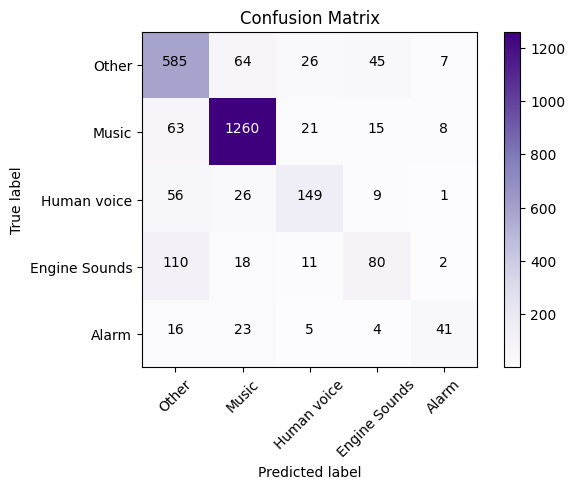

AUC score: 0.9329536749859617


In [12]:
# Save model
# model.save(os.path.join(models_path, "model_5"))
#Load model
# model = load_model(os.path.join(models_path, "model_5"))

# Set evaluation data, predict and evaluate
# If there's a test set, that will be used as evaluation data, otherwise we use the validation set
x_eval = x_test
y_eval = y_test

# Make predictions and evaluate model
y_prob, y_pred = make_predictions(x_eval)
evaluate_model(y_prob, y_pred, y_eval)

## Model 6: Train model giving higher priority to classes with less data


Epoch 1/10
1323/1323 [==============================] - 61s 46ms/step - loss: 1.3226 - accuracy: 0.5107 - val_loss: 0.9552 - val_accuracy: 0.6339
Epoch 2/10
1323/1323 [==============================] - 64s 48ms/step - loss: 0.9932 - accuracy: 0.6254 - val_loss: 0.8708 - val_accuracy: 0.6608
Epoch 3/10
1323/1323 [==============================] - 74s 56ms/step - loss: 0.8487 - accuracy: 0.6783 - val_loss: 0.9222 - val_accuracy: 0.6560
Epoch 4/10
1323/1323 [==============================] - 65s 49ms/step - loss: 0.7436 - accuracy: 0.7131 - val_loss: 0.9408 - val_accuracy: 0.6550
Epoch 5/10
1323/1323 [==============================] - 65s 49ms/step - loss: 0.6624 - accuracy: 0.7409 - val_loss: 0.7651 - val_accuracy: 0.7119
Epoch 6/10
1323/1323 [==============================] - 71s 54ms/step - loss: 0.5855 - accuracy: 0.7670 - val_loss: 0.7763 - val_accuracy: 0.7154
Epoch 7/10
1323/1323 [==============================] - 69s 52ms/step - loss: 0.5467 - accuracy: 0.7791 - val_loss: 0.7537 -

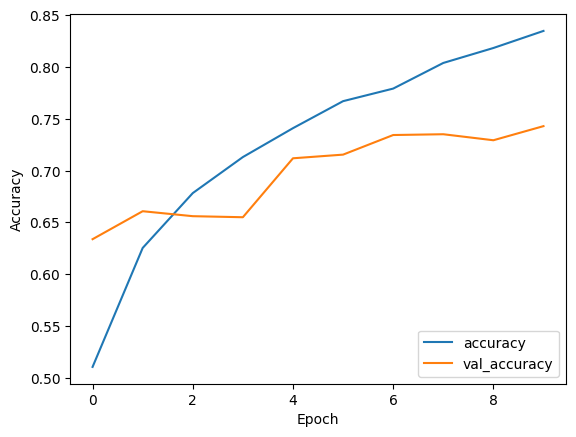

In [19]:
%%time
# Compute class weights based on the training labels
class_weights = compute_class_weight('balanced', classes=[0,1,2,3,4], y=Y)

# Split the data using StratifiedShuffleSplit
# We set the random_state parameter to a fixed value (42) to ensure that the splits are reproducible.
x_train, y_train, x_val, y_val, x_test, y_test = split_data_stratified(X, Y, val_size_ratio=0.15, test_size_ratio=0.05)

# Build the neural network
model = tf.keras.Sequential([
  layers.Input(shape=(32, 96, 1)),
  layers.Conv2D(16, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(5, activation='softmax')
])

# Train the neural network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=40, validation_data=(x_val, y_val),
                    sample_weight=class_weights[y_train])

# Plot the history
plot_history(history)


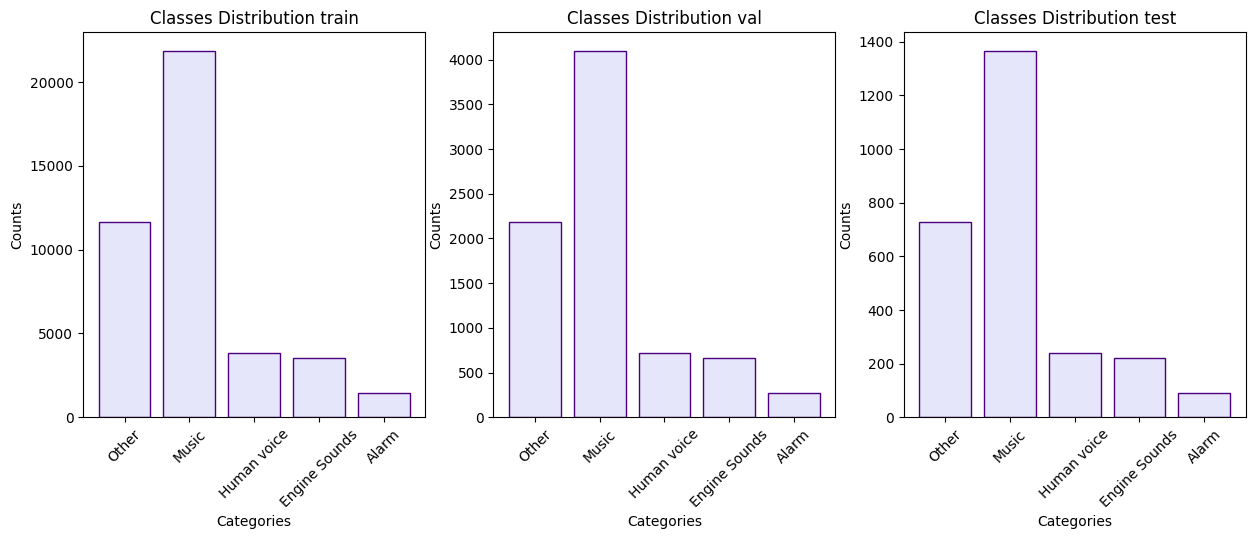

83/83 [==============================] - 1s 13ms/step
Classification report:
               precision    recall  f1-score   support

           0       0.74      0.56      0.63       727
           1       0.94      0.84      0.88      1367
           2       0.55      0.72      0.63       241
           3       0.36      0.73      0.48       221
           4       0.49      0.63      0.55        89

    accuracy                           0.73      2645
   macro avg       0.62      0.69      0.64      2645
weighted avg       0.78      0.73      0.75      2645



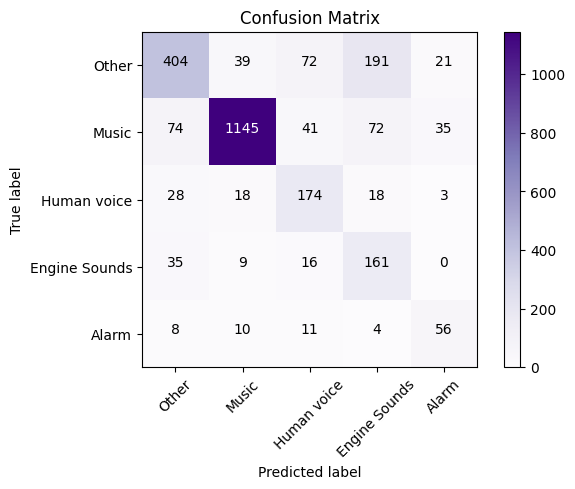

AUC score: 0.9218149497107305


In [21]:
# Show subsets distribution
plot_sets_dist(y_train, y_val, y_test)

# Save model
# model.save(os.path.join(models_path, "model_6"))
#Load model
# model = load_model(os.path.join(models_path, "model_6"))

# Set evaluation data, predict and evaluate
# If there's a test set, that will be used as evaluation data, otherwise we use the validation set
x_eval = x_test
y_eval = y_test

# Make predictions and evaluate model
y_prob, y_pred = make_predictions(x_eval)
evaluate_model(y_prob, y_pred, y_eval)

## Make predictions on new data

168/168 [==============================] - 3s 18ms/step
Model predicting time: 5.256610155105591 seconds
Time per prediction: 0.0009830952225744513 seconds
{'Other': 1943, 'Music': 2378, 'Human voice': 459, 'Engine Sounds': 397, 'Alarm': 170}


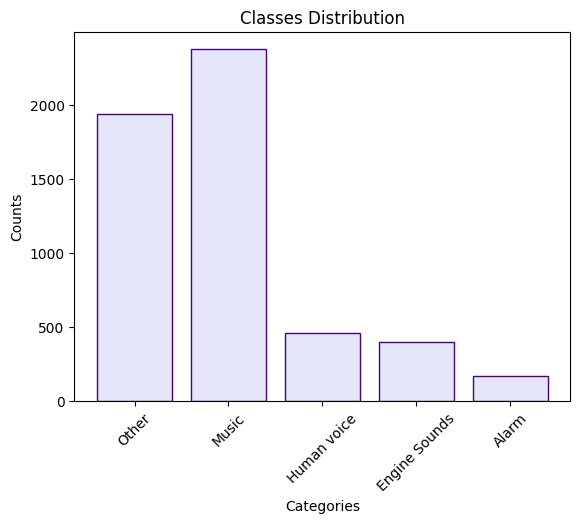

In [31]:
# Load model
model = load_model(os.path.join(models_path, "model_2"))

# Make predictions
make_final_predictions_csv(X_test)

### See all models predictions

168/168 [==============================] - 2s 14ms/step
Model predicting time: 2.6528537273406982 seconds
Time per prediction: 0.0004961387184104541 seconds
{'Other': 2018, 'Music': 2006, 'Human voice': 681, 'Engine Sounds': 484, 'Alarm': 158}


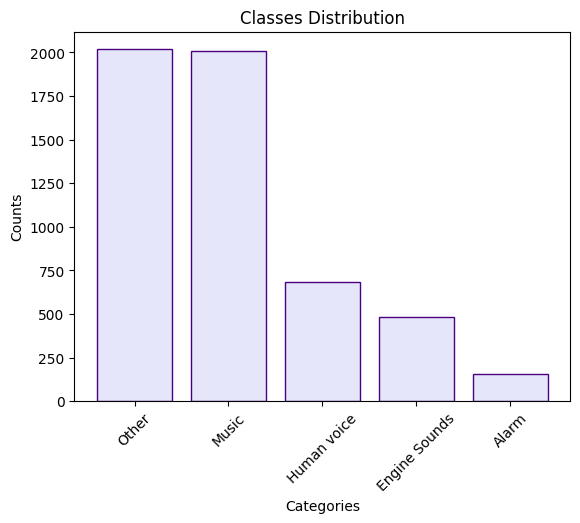

168/168 [==============================] - 2s 14ms/step
Model predicting time: 2.50718355178833 seconds
Time per prediction: 0.0004688953715706621 seconds
{'Other': 1943, 'Music': 2378, 'Human voice': 459, 'Engine Sounds': 397, 'Alarm': 170}


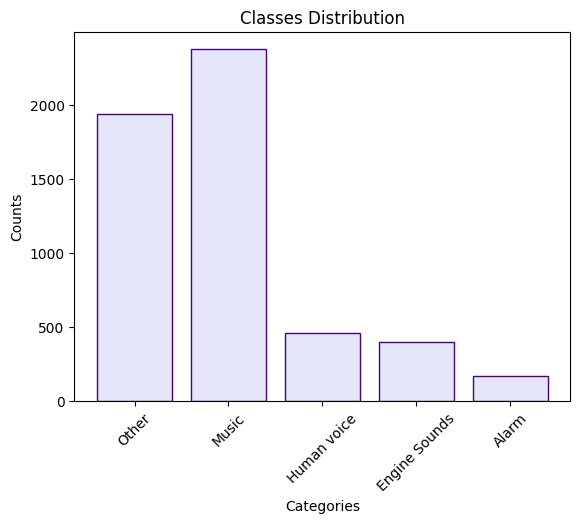

168/168 [==============================] - 2s 13ms/step
Model predicting time: 2.664706230163574 seconds
Time per prediction: 0.0004983553824880445 seconds
{'Other': 1986, 'Music': 2136, 'Human voice': 643, 'Engine Sounds': 478, 'Alarm': 104}


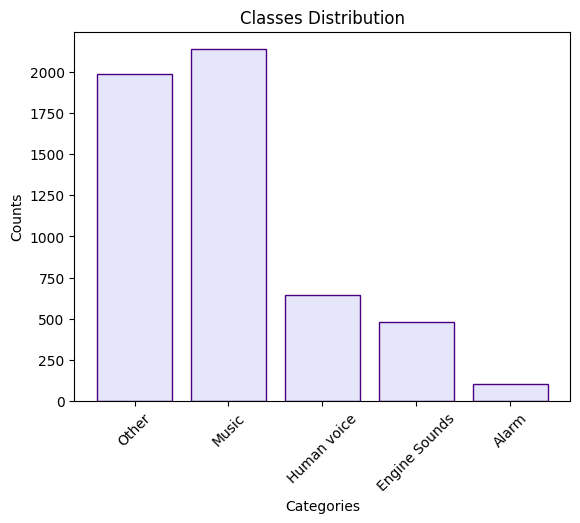

168/168 [==============================] - 2s 13ms/step
Model predicting time: 2.660099506378174 seconds
Time per prediction: 0.0004974938295077938 seconds
{'Other': 2301, 'Music': 2272, 'Human voice': 427, 'Engine Sounds': 282, 'Alarm': 65}


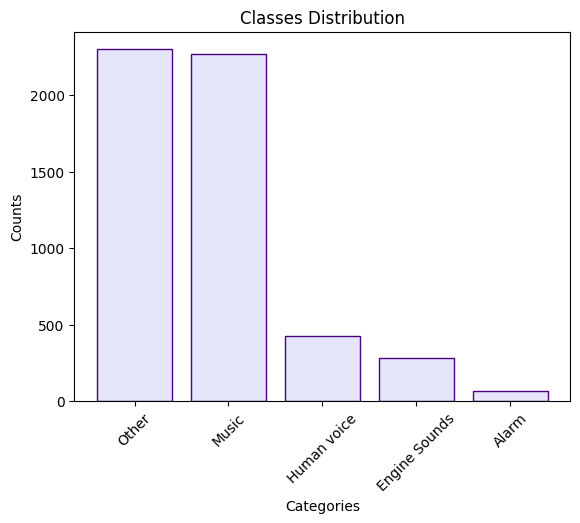

168/168 [==============================] - 3s 17ms/step
Model predicting time: 3.041940450668335 seconds
Time per prediction: 0.0005689060128424041 seconds
{'Other': 2417, 'Music': 2155, 'Human voice': 400, 'Engine Sounds': 301, 'Alarm': 74}


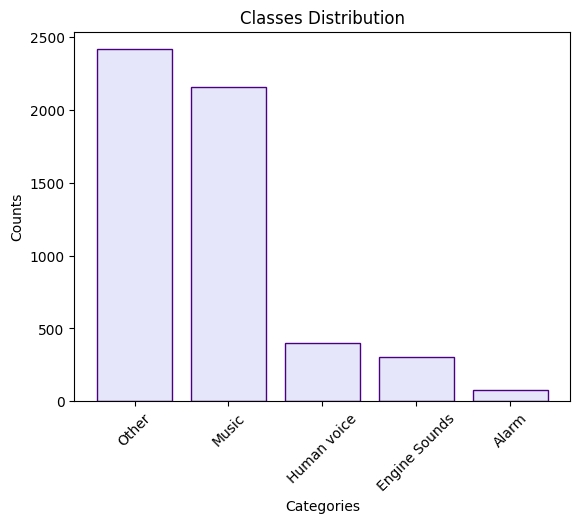

168/168 [==============================] - 2s 14ms/step
Model predicting time: 2.7457175254821777 seconds
Time per prediction: 0.0005135061764507533 seconds
{'Other': 1651, 'Music': 1762, 'Human voice': 697, 'Engine Sounds': 1038, 'Alarm': 199}


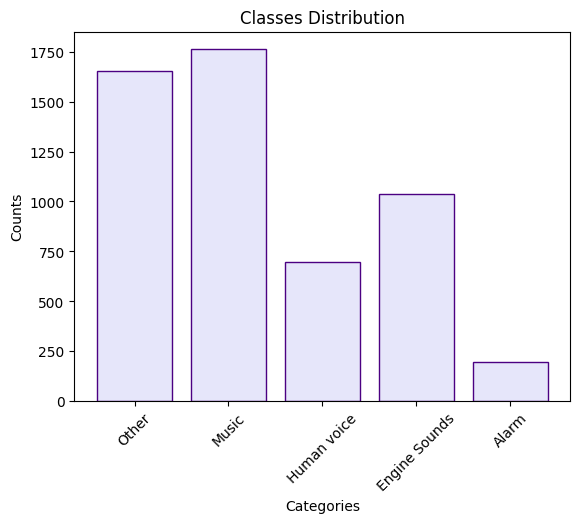

In [32]:
for i in range(1, 7):
    model = load_model(os.path.join(models_path, f"model_{i}"))
    make_final_predictions_txt(X_test)